<a href="https://colab.research.google.com/github/ikanx101/ikanx101.github.io/blob/master/Harga_Mobil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
# install libraries dulu
  # install.packages("keras")
  # install.packages("DALEX")
  # install.packages("caret")
  # install.packages("tensorflow")

In [56]:
rm(list=ls())
library(dplyr)
library(keras)
library(tensorflow)
library(DALEX)
library(caret)
library(pROC)
set.seed(21121986)

load("clean.rda")

In [57]:
clean %>% str()

tibble [549 × 8] (S3: tbl_df/tbl/data.frame)
 $ harga  : num [1:549] 1.38e+08 3.30e+08 8.50e+07 2.90e+08 4.85e+08 1.10e+08 2.25e+08 1.10e+08 2.15e+08 2.45e+08 ...
 $ brand  : chr [1:549] "Toyota" "Volkswagen" "Daihatsu" "Toyota" ...
 $ status : chr [1:549] "Used Car" "Used Car" "Used Car" "Used Car" ...
 $ year   : chr [1:549] "2017" "2014" "2015" "2018" ...
 $ seat   : chr [1:549] "7" "4" "5" "5" ...
 $ mileage: num [1:549] 50000 55000 95000 15000 1000 1000 1000 1000 1000 1000 ...
 $ mesin  : num [1:549] 1329 1390 998 1798 2393 ...
 $ target : num [1:549] 18.7 19.6 18.3 19.5 20 ...


In [58]:
# ubah status
cat("==========\nAwal:")
table(clean$status)

clean =
  clean %>%
  mutate(status = ifelse(status == "New Car",0,1))

cat("\n\n==========\nHasil:")
table(clean$status)

# one hot encoding pake KERAS
status = to_categorical(clean$status)
status = as.data.frame(status) %>% rename(new_car = V1,used_car = V2) # kita simpan dulu

Awal:


 New Car Used Car 
      63      486 



Hasil:


  0   1 
 63 486 

In [59]:
# sekarang ubah yang gampang
# tahun dan seat
clean = 
  clean %>%
  mutate(year = as.numeric(year),
         seat = as.numeric(seat))

clean %>% str()

tibble [549 × 8] (S3: tbl_df/tbl/data.frame)
 $ harga  : num [1:549] 1.38e+08 3.30e+08 8.50e+07 2.90e+08 4.85e+08 1.10e+08 2.25e+08 1.10e+08 2.15e+08 2.45e+08 ...
 $ brand  : chr [1:549] "Toyota" "Volkswagen" "Daihatsu" "Toyota" ...
 $ status : num [1:549] 1 1 1 1 1 1 1 1 1 1 ...
 $ year   : num [1:549] 2017 2014 2015 2018 2019 ...
 $ seat   : num [1:549] 7 4 5 5 7 7 7 7 5 7 ...
 $ mileage: num [1:549] 50000 55000 95000 15000 1000 1000 1000 1000 1000 1000 ...
 $ mesin  : num [1:549] 1329 1390 998 1798 2393 ...
 $ target : num [1:549] 18.7 19.6 18.3 19.5 20 ...


In [60]:
# one hot encoding dengan CARET
tes = data.frame(clean$brand)
dummy = dummyVars(" ~ .", data=tes)
newdata = data.frame(predict(dummy, newdata = tes)) 

# kita simpan dulu newdata

In [61]:
# kita ubah dulu data yang range nya tinggi yah
pre_pro = clean %>% select(target,year,seat,mileage,mesin)
preProcess_range_model = preProcess(pre_pro, method='range')
transform = predict(preProcess_range_model, newdata = pre_pro) 

# saatnya gabung semua bagian
ready = data.frame(transform,status)
ready = data.frame(ready,newdata)

ready %>% str()

'data.frame':	549 obs. of  33 variables:
 $ target                  : num  0.214 0.434 0.092 0.401 0.531 ...
 $ year                    : num  0.84 0.72 0.76 0.88 0.92 0.8 0.88 0.56 0.64 0.64 ...
 $ seat                    : num  0.357 0.143 0.214 0.214 0.357 ...
 $ mileage                 : num  0.14179 0.15609 0.27052 0.04167 0.00162 ...
 $ mesin                   : num  0.1393 0.1501 0.0803 0.2228 0.3288 ...
 $ new_car                 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ used_car                : num  1 1 1 1 1 1 1 1 1 1 ...
 $ clean.brandAudi         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ clean.brandBMW          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ clean.brandChevrolet    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ clean.brandDaihatsu     : num  0 0 1 0 0 1 0 1 0 0 ...
 $ clean.brandDatsun       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ clean.brandFord         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ clean.brandHonda        : num  0 0 0 0 0 0 0 0 1 0 ...
 $ clean.brandHummer       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ cl

In [63]:
# kita mulai fun partnya
id = sample(549,450,replace = F)

# train dataset
train = ready[id,] 
train_label_raw = train$target
train_matrix = train %>% select(-target) %>% as.matrix()

# test dataset
test = ready[-id,] 
test_label_raw = test$target
test_matrix = test %>% select(-target) %>% as.matrix()

In [66]:
# kita cek dulu ada berapa dimensinya
train_matrix %>% str()

# model KERAS
model = keras_model_sequential()
model %>%
  layer_dense(units = 32,activation = 'relu',
              input_shape = c(ncol(train_matrix))) %>%
  layer_dense(units = 20, activation = 'sigmoid') %>%
  layer_dense(units = 15, activation = 'sigmoid') %>%
  layer_dense(units = 8, activation = 'relu') %>%
  layer_dense(units = 1)
summary(model)

# optimizer
model %>% compile(
  loss='mse',
  optimizer = optimizer_rmsprop(),
  metrics =  list("mean_absolute_error")
)

# training epoch
fitModel =
  model %>%
  fit(train_matrix,
      train_label_raw,
      epochs = 200,
      batch_size = 15,
      validation_split = 0.15)

# plot hasilnya
plot_model_keras = plot(fitModel)

 num [1:450, 1:32] 0.84 0.64 0.88 0.96 0.88 0.64 0.64 0.8 0.96 1 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:450] "230" "12" "109" "367" ...
  ..$ : chr [1:32] "year" "seat" "mileage" "mesin" ...
Model: "sequential_1"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_9 (Dense)                     (None, 32)                      1056        
________________________________________________________________________________
dense_8 (Dense)                     (None, 20)                      660         
________________________________________________________________________________
dense_7 (Dense)                     (None, 15)                      315         
________________________________________________________________________________
dense_6 (Dense)                     (None, 8)                       128         
_____________________________________________

`geom_smooth()` using formula 'y ~ x'



Preparation of a new explainer is initiated
  -> model label       :  Keras Regression 
  -> data              :  99  rows  32  cols 
  -> target variable   :  99  values 
  -> predict function  :  yhat.default will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package Model of class: keras.engine.sequential.Sequential package unrecognized , ver. Unknown , task regression (  default  ) 
  -> model_info        :  type set to  regression 
  -> predicted values  :  numerical, min =  0.06000447 , mean =  0.3414176 , max =  0.7436416  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -0.1786935 , mean =  0.03586456 , max =  0.2856635  
  A new explainer has been created!  


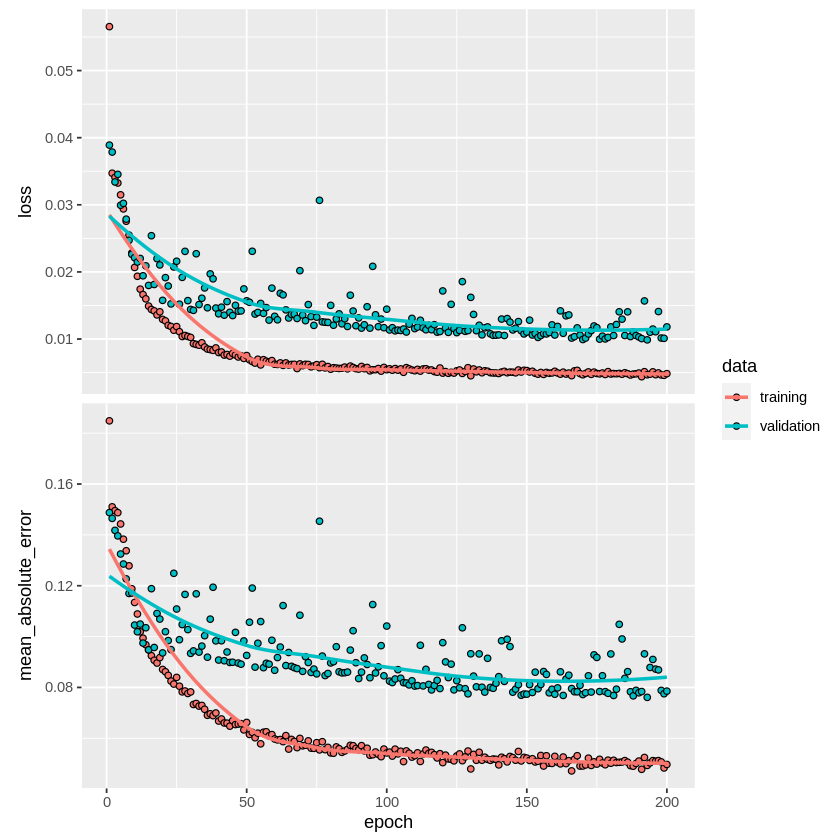

In [68]:
# plot hasilnya
plot_model_keras

# explainer
explainer_model_keras = explain(model = model,
                                data = test_matrix,
                                y = test_label_raw,
                                type = "regression",
                                label = "Keras Regression",
                                colorize = FALSE)


In [69]:
# model explainer
performa_model = model_performance(explainer_model_keras)
performa_model

Measures for:  regression
mse        : 0.008530676 
rmse       : 0.09236166 
r2         : 0.7348903 
mad        : 0.04116692

Residuals:
          0%          10%          20%          30%          40%          50% 
-0.178693546 -0.053080665 -0.031336341 -0.009975249  0.013205092  0.024046387 
         60%          70%          80%          90%         100% 
 0.037722285  0.048109418  0.079803492  0.189394098  0.285663537 

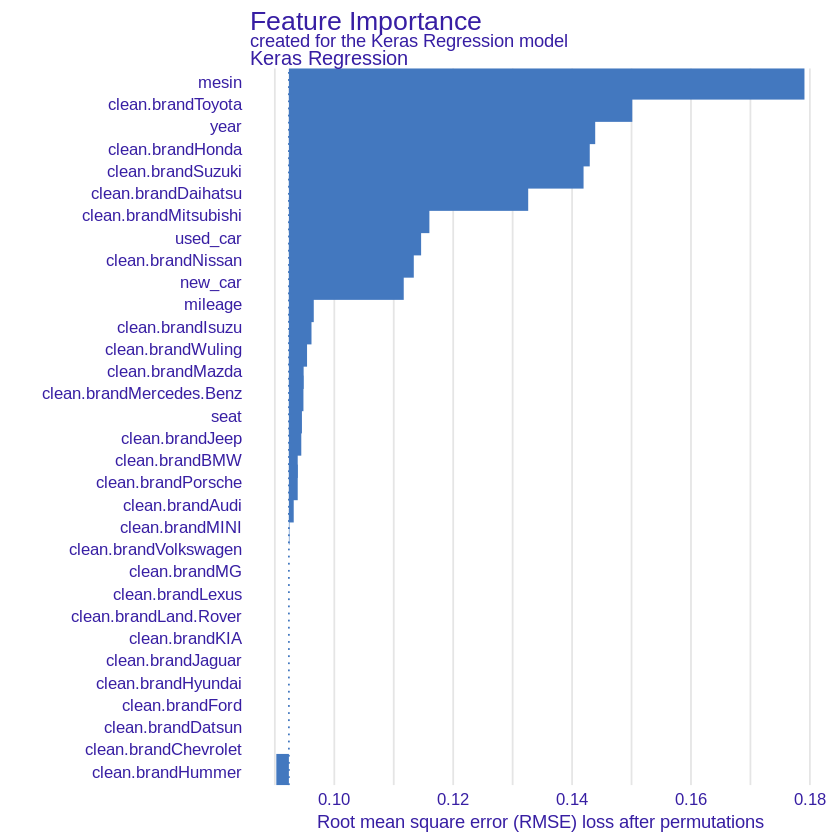

In [71]:
# variable importance
var_importante = model_parts(explainer_model_keras)
plot_importance = plot(var_importante,show_boxplots = FALSE)
plot_importance

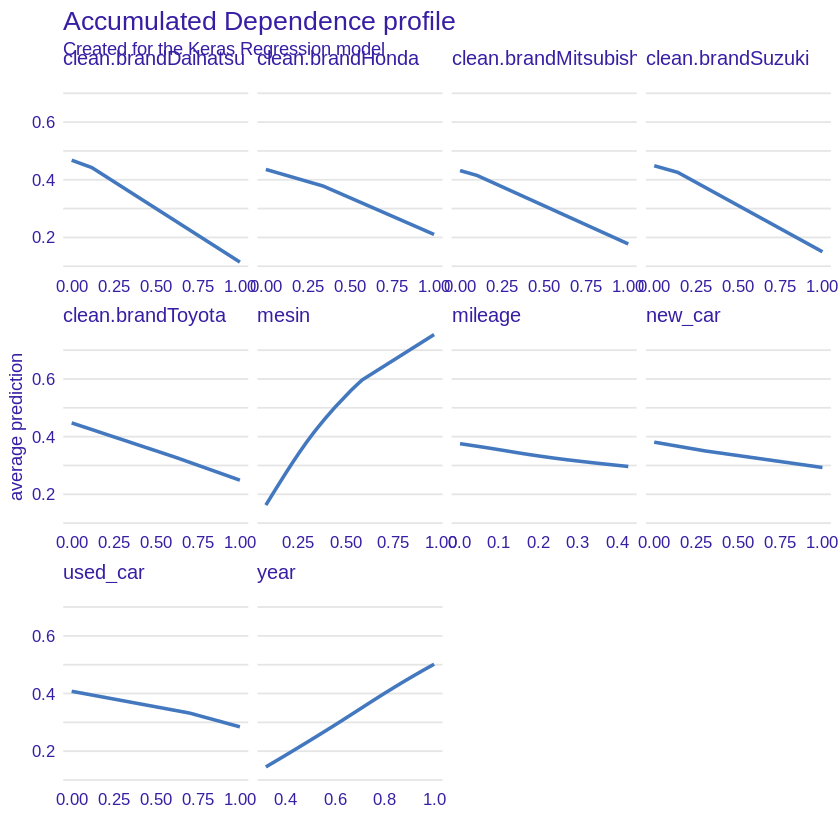

In [75]:
# model profile
mp_ball = model_profile(explainer_model_keras, 
                        variable =  c("mesin","clean.brandToyota","year","mileage","clean.brandHonda","clean.brandSuzuki",
                                      "clean.brandDaihatsu","clean.brandMitsubishi","used_car","new_car"), 
                        type = "accumulated")
plot(mp_ball)


In [76]:
save(ready,train_matrix,test_matrix,plot_model_keras,performa_model,plot_importance,mp_ball,file = "siap_post.rda")